In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import matplotlib.cm as cm
from IPython.display import Image, display

# Praca domowa 5
Celem zadania jest zastosowanie metod XAI w celu przeanalizowania na jakiej podstawie sieć neuronowa wygenerowała predykcje. Przykładowym modelem będzie sieć ResNet50 wyuczona na zbiorze ImageNet.

## ResNet
Jednym z problemów bardzo głębokich sieci neronowych jest zjawisko zanikania gradientu. Podczas propagacji wstecznej, wyliczane wartości gradientu dla coraz płytszych warstw są coraz mniejsze. Problem ten rozwiązuje architektura ResNet (residual network) korzystając ze skrótowych połączeń pomiędzy warstwami konwolucyjnymi. Wartości z wcześniejszych warstw zostają dodane do wartości późniejszych warstw. Jako że wartstwy konwolucyjne zwykle zmieniają rozmiar macierzy, w razie potrzeby w połączeniu skokowym zostaje wykorzystana identycznościowa operacja konwolucji, tak aby rozmiar macierzy się zgadzał i można było przeprowadzić dodawanie. [[Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition. 2015](https://arxiv.org/abs/1512.03385)] 

![](residual_block.png)

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')

#### Przykład działania sieci

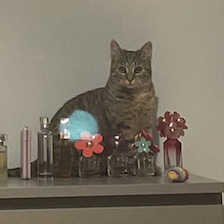

In [3]:
from matplotlib.image import imread
img_cat = image.load_img('IMG_1207.jpg', target_size=(224,224))
img_cat

In [4]:
img_cat = preprocess_input(image.img_to_array(img_cat))
pred = model.predict(img_cat.reshape(1,224,224,3))

In [5]:
decode_predictions(pred)

[[('n02124075', 'Egyptian_cat', 0.4361079),
  ('n02123045', 'tabby', 0.27515605),
  ('n02870880', 'bookcase', 0.045275815),
  ('n02123159', 'tiger_cat', 0.041103147),
  ('n04404412', 'television', 0.017211463)]]

## GradCAM
Jednym z metod XAI dla sieci konwolucyjnych jest GradCAM (Gradient-weighted Class Activation Mapping). Metoda ta obrazuje na podstawie jakich obszarów obrazu model dokonał klasyfikacji. 

In [10]:
# implementacja GradCAM ze strony dokumentacji Keras - https://keras.io/examples/vision/grad_cam/
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    display(Image(cam_path))
    
model = ResNet50(weights='imagenet')
model.layers[-1].activation = None

Przykładowa wygenerowana heatmapa nałożona na obrazek. Potrzebne było przekazanie fukncji nazwę ostataniej warstwy konwolucyjnej, w tym przypadku jest to `conv5_block3_out`.

Predicted: [[('n02124075', 'Egyptian_cat', 0.4361079), ('n02123045', 'tabby', 0.27515605), ('n02870880', 'bookcase', 0.045275815)]]


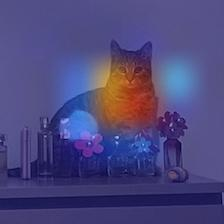

In [68]:
img_array_cat = preprocess_input(get_img_array('IMG_1207.jpg', size=(224,224)))

preds_cat = model.predict(img_array_cat)
print("Predicted:", decode_predictions(preds_cat, top=3))

heatmap = make_gradcam_heatmap(img_array_cat, model, 'conv5_block3_out')

save_and_display_gradcam('IMG_1207.jpg',heatmap, alpha=0.95)

Na kolejnym przykladzie widać że uwaga została skupiona na czerwonym samochodzie. W top wyznaczonych klasach nie ma klas zbliżonych do pickupa. Możemy wyznaczyć heatmapę dla `minivan`, być może heatmapa obejmie chodź trochę obszar gdzie znajduje się pickup.

Predicted: [[('n04285008', 'sports_car', 0.3346854), ('n04037443', 'racer', 0.12851863), ('n03770679', 'minivan', 0.12711902), ('n02930766', 'cab', 0.09438506)]]


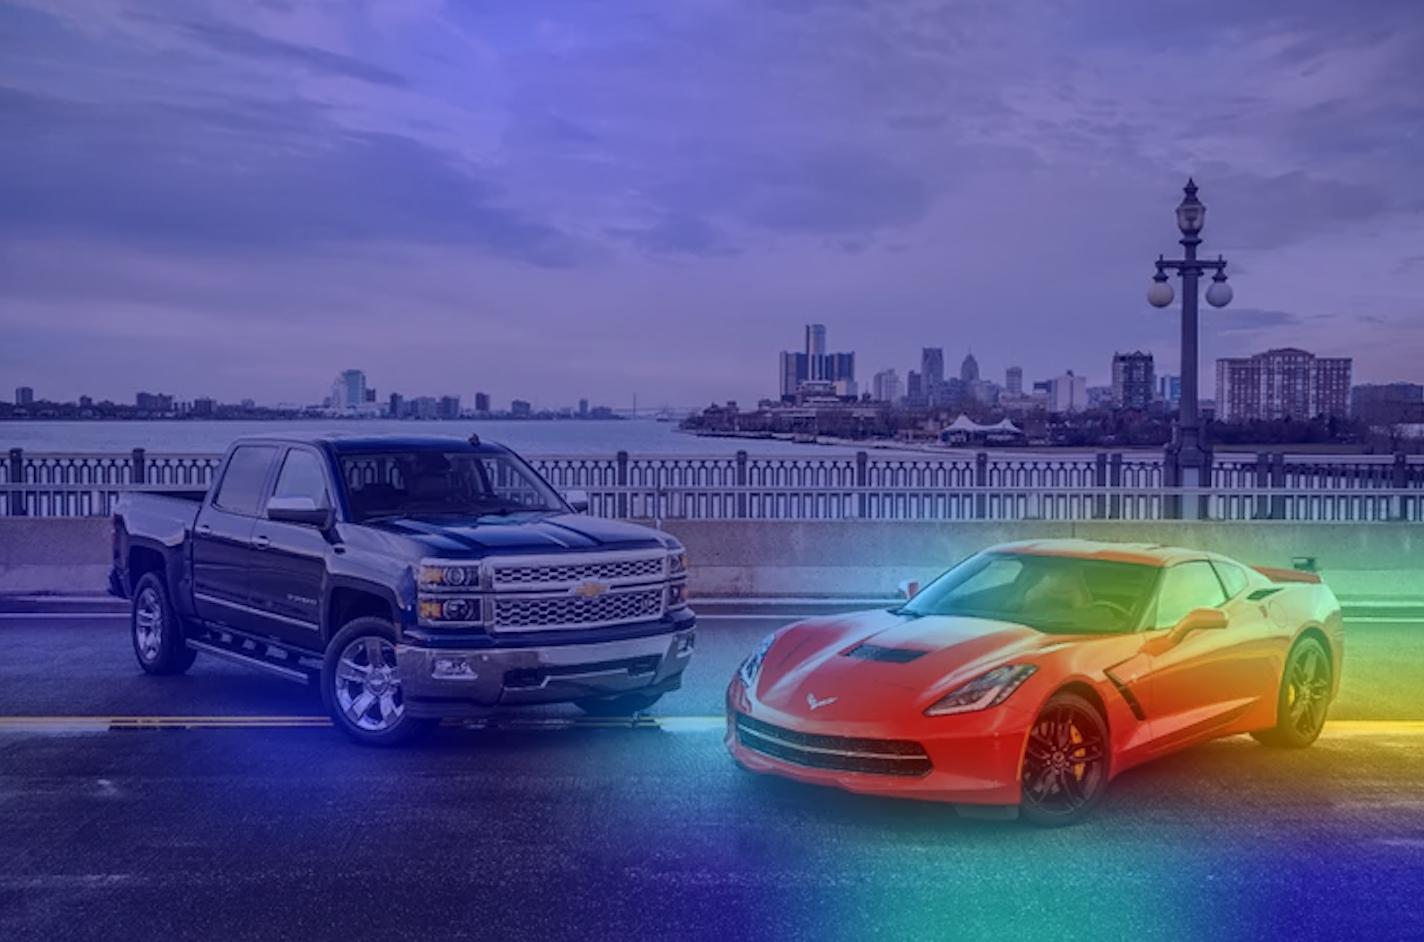

In [76]:
img_array_cars = preprocess_input(get_img_array('cartruck.jpg', size=(224,224)))
preds = model.predict(img_array_cars)
print("Predicted:", decode_predictions(preds, top=4))
heatmap = make_gradcam_heatmap(img_array_cars, model, 'conv5_block3_out')
save_and_display_gradcam('cartruck.jpg',heatmap, alpha=0.95)

Tak można się było spodziewać, heatmapa teraz wskazuje na pickupa. Największe wartości są w obszarze gdzie znajduje się przód pickupa, co ma sens ponieważ podobny przód mogą mieć minivany.

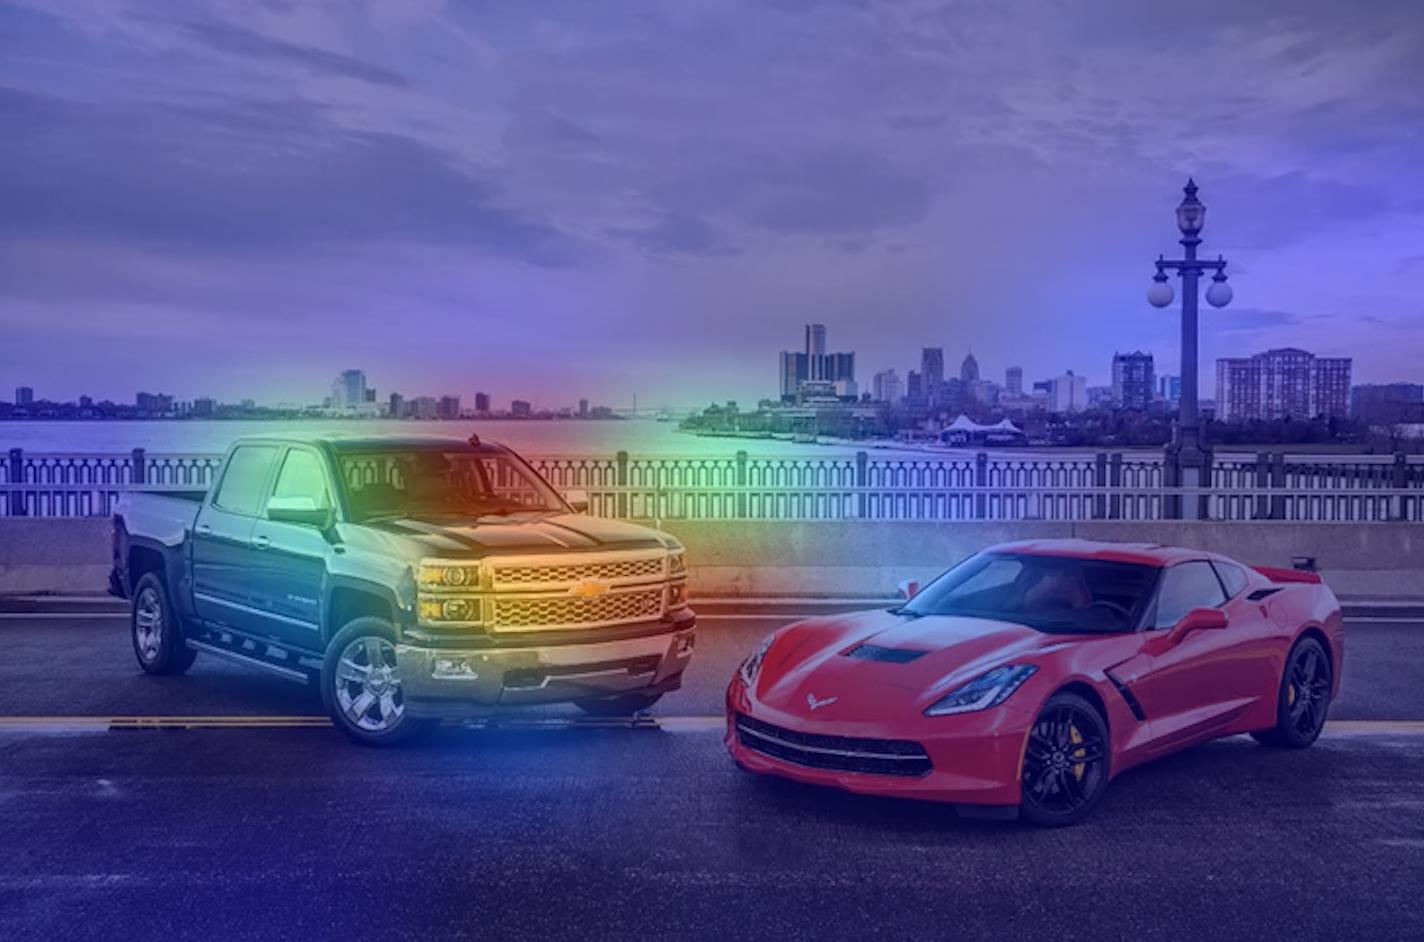

In [77]:
heatmap = make_gradcam_heatmap(img_array_cars, model, 'conv5_block3_out', pred_index=656)
save_and_display_gradcam('cartruck.jpg',heatmap, alpha=0.95)

## LIME
LIME jest kompletną biblioteką XAI. Jest w stanie m.in. tak jak GradCAM oznaczyć obszary obrazu na których opierał się model podczas klasyfikacji. By użyć tego narzędzia na naszym przykładzie należy go najpierw przeanalizować obiektem `LimeImageExplainer` co trwa kilka minut.

In [13]:
# na podstawie przykladow zawartych w repozytorium LIME - https://github.com/marcotcr/lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
model = ResNet50(weights='imagenet')
explainer = lime_image.LimeImageExplainer()
explanation_cat = explainer.explain_instance(img_array_cat[0].astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


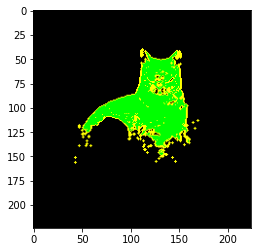

In [63]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation_cat.get_image_and_mask(explanation_cat.top_labels[0],
                                                positive_only=False,
                                                hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Metoda `get_image_and_masks`posiada wiele parametrów, na przykład `min_weight` która pozwala przefiltrować najbardziej znaczące obszary zdjęcia dla klasyfikacji. Zwiększmy minimalną wagę wyświetlanych obszarów. Widać teraz że większe znaczenie przy podejmowaniu dycyzji mogło mieć umaszczenie kota niż jego kontury.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


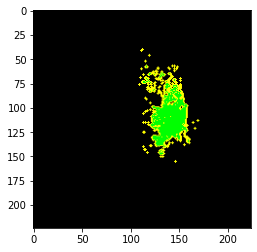

In [65]:
temp, mask = explanation_cat.get_image_and_mask(explanation_cat.top_labels[0],
                                                positive_only=False,
                                                hide_rest=True, min_weight=0.05)
plt.imshow(mark_boundaries(temp, mask))

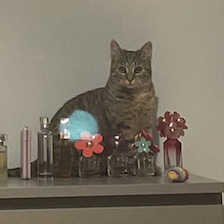

In [73]:
# oryginalne zdjecie dla przypomnienia
image.load_img('IMG_1207.jpg', target_size=(224,224))

Zaraz za klasą `Egyptian_cat` wyznaczoną została klasa `tabby` czyli ogólniejsze pojęcie kota niż konkretna rasa. Możemy sprawdzić jakie obszary były ważne dla tej klasy.

In [74]:
decode_predictions(preds_cat, top=3)

[[('n02124075', 'Egyptian_cat', 0.4361079),
  ('n02123045', 'tabby', 0.27515605),
  ('n02870880', 'bookcase', 0.045275815)]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


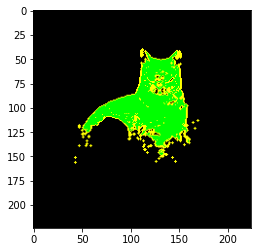

In [55]:
temp, mask = explanation_cat.get_image_and_mask(explanation_cat.top_labels[1],
                                                positive_only=False, num_features=10,
                                                hide_rest=True, min_weight=0.05)
plt.imshow(mark_boundaries(temp, mask))

W przypadku ogólniejszej klasy, widać że główną rolę odgrywały ogólne kształty niż szczegóły umaszczenia.

## Wnioski
GradCAM i LIME są bardzo pomocne w zrozumieniu działania modelu. Czasem model zwraca uwagę na inne elementy obiektu niż moglibyśmy się spodziewać. LIME pozwala na precyzyjniejszą analizę, z większą możliwościa doboru paramatrów niż przykładowa implementacja GradCAM. Jednak dużym minusem jest długi czas analizowania pojedycznego przykładu. Dobrym zastosowaniem powyższych narzędzi może być "debugowanie" działania modeli analizująć źle sklasyfikowane obserwacje, co będzie pomocne np. w decyzji zmiany sposobu augmentacji danych by poprawić błędne klasyfikacje.